In [1]:
# 1. 기본 데이터 처리, 정규식, 문자열처리 라이브러리
import numpy as np
import pandas as pd
import re
import string

# 2. 텍스트 처리 라이브러리
#from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import konlpy
from konlpy.tag import Okt

# 3. 문자 빈도, 문자특성 추출, 워드클라우드
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

# 4. 데이터문서 및 날짜처리 라이브러리
from itertools import chain
import pickle
from datetime import datetime

# 5. 도표 및 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import font_manager
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
import sys
import datetime
import os
import requests
from bs4 import BeautifulSoup
import re
import pdb

# 작업 폴더 재설정(분석할 파일이나 corpus 있는 곳,)
WORK_HOME = r'C:\Users\Yun\Desktop\22 겨울방학\job'
os.chdir(WORK_HOME)   # 작업 폴더 이동 (UTagger 초기화: 사전 및 dll 라이브러리 interface 호출)

In [3]:
Data = pd.read_csv('job.csv', encoding='utf-8')

In [4]:
Data.head()

,회사명,직무,링크,자격요건,우대사항
0,데이터라이즈,Backend Engineer,https://www.wanted.co.kr/wd/81841,• 3년 이상의 실무 경험 또는 그에 준하는 이해도가 있으신 분 \n• 1개 이상의...,• 좋은 코드와 설계를 위한 고민 그리고 테스트의 중요성을 인지하고 계신 분\n• ...
1,데이터라이즈,Data Engineer,https://www.wanted.co.kr/wd/81834,"• 데이터 수집, 전처리 중 1개 이상 구축 경험이 있는 1년 이상의 경력자 또는 ...",• 좋은 코드와 설계를 위한 고민 그리고 테스트의 중요성을 인지하고 계신 분\n• ...
2,데이터비,AI Engineer (ML/DL),https://www.wanted.co.kr/wd/64852,"- Python을 이용한 개발 경험 (pytorch, tensorflow, scik...",- 데이터와 소프트웨어 기술이 사람간의 의사소통을 더 원활하게 도울 수 있다고 믿는...
3,윙잇,[윙잇] 데이터 분석가,https://www.wanted.co.kr/wd/133324,■[이런 분과 함께하고 싶어요]\n• 데이터 분석 관련 경력 3년 이상 보유하신 분...,■[이런 분이면 더욱 좋아요]\n• 프로그래밍 언어 구현 능력 있으신 분\n• 컴퓨...
4,로이드케이,빅데이터 솔루션 데이터 엔지니어,https://www.wanted.co.kr/wd/144903,"ㆍ서버 (Linux, Windows Server) 개념 이해 및 경험\nㆍDBMS ...","ㆍ컴퓨터/정보통신/보안/시스템 공학계열 전공자\nㆍ정보처리(산업)기사, 리눅스마스터..."


In [5]:
QR_K = Data['자격요건'].copy()
QR_E = Data['자격요건'].copy()

In [6]:
okt = konlpy.tag.Okt()

def clean_korean_documents(documents):

    for i, document in enumerate(documents):
            # 1. 텍스트 정제 (HTML 태그 제거)
            #document = BeautifulSoup(document, 'html.parser').text 

            # 2. 텍스트 정제 (특수기호 제거)
            #pdb.set_trace()
            document = re.sub(r'[^ ㄱ-ㅎㅣ가-힣]', ' ', document) # 한글, blank 외의 문자= > 제거특수기호 제거
            document = re.sub(r'(\s+)',' ', document)  # 연속적인 ' ' 를 하나로 

            # 3. 텍스트 정제 (형태소 추출)
            clean_words = []
            for word in okt.pos(document, stem=True): #어간 추출
                if word[1] in ['Noun', 'Adjective']: #명사, 형용사 okt.tagsets 참조
                    clean_words.append(word[0])
                    
            documents[i] = clean_words               # 이 경우 join 되지 않은 리스트 생성 ( ','로 구분 리스트)
    return documents

In [7]:
def clean_english_documents(documents):

    for i, document in enumerate(documents):
        
        # 영문자 이외 문자는 공백으로 변환
        document = re.sub(r'[^ a-zA-Z]+', '', document)  #영문 제외
        document = re.sub(r'(\s+)',' ', document)  # 연속적인 ' ' 를 하나로 


        # 소문자 변환
        no_capitals = document.lower().split()

        # 불용어 제거
        stops = set(stopwords.words('english'))
        no_stops = [word for word in no_capitals if not word in stops]
        
        
        documents[i] = no_stops
    return documents

In [8]:
# 전처리 기본 함수 적용하여 PrePrecessed_TEXT 데이터셋(리스트) 생성

Cleaned_QR_K = clean_korean_documents(QR_K)

In [9]:
Cleaned_QR_E = clean_english_documents(QR_E)

In [10]:
def lengthTxt(func):
    newTxt = []
    for doc in func:
        filteredTxt = [w for w in doc if len(w) > 1]
        newTxt.append(filteredTxt)
    return newTxt

In [11]:
Finished_QR_K = lengthTxt(Cleaned_QR_K)

In [12]:
# 3. 문자 빈도, 문자특성 추출, 워드클라우드
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from itertools import chain

In [13]:
# stopword 제거
def replaceTxt(func, old, new):
    newList = []
    for doc in func:
        newTxt = []
        for w in doc:
            newTxt.append(w.replace(old, new))
        newList.append(newTxt)
    return newList

In [14]:
# 모든 리스트를 하나로 연결하여 어휘 빈도 count (최대 어휘수 지정)
#print(Counter(list(chain.from_iterable(Finished_QR_K))).most_common(1000))

In [15]:
Finished_QR_K = replaceTxt(Finished_QR_K, '있다', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '이상', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '대한', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '활용', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '능숙하다', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '기본', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '가지', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '높다', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '무관', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '통한', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '계시다', '')
Finished_QR_K = replaceTxt(Finished_QR_K, '많다', '')

In [16]:
#print(Counter(list(chain.from_iterable(Cleaned_QR_E))).most_common(1000))

In [17]:
Finished_QR = Finished_QR_K + Cleaned_QR_E

C:\Users\Yun\anaconda3\lib\site-packages\pandas\core\roperator.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return right + left


In [18]:
#print(Counter(list(chain.from_iterable(Finished_QR))).most_common(1000))

In [19]:
# 문서별 선정된 어휘를 하나의 문장으로 연결
def joinTxt(func):
    newTxt = []
    for doc in func:
        newTxt.append(" ".join(doc))
    return newTxt

In [20]:
# 함수 적용
Finished_QR_JOIN = joinTxt(Finished_QR)

In [21]:
import pickle

with open('Finished_QR.bin', 'wb') as fp:
    pickle.dump(Finished_QR, fp)

In [22]:
import pickle

with open('Finished_QR_JOIN.bin', 'wb') as fp:
    pickle.dump(Finished_QR_JOIN, fp)

In [23]:
# 전처리 완료된 데이터 중 조인(join)된 데이터 불러오기
with open('Finished_QR_JOIN.bin', 'rb') as fp:
    qr_ko_word = pickle.load(fp)

In [24]:
cv=CountVectorizer(max_features=200)
dtm=cv.fit_transform(qr_ko_word)
words=cv.get_feature_names()

C:\Users\Yun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# 1. 단어 합계계산
# 2. 2차원을 1차원으로 변경(squeeze)
# 3. 단어명-단어빈도 결합
# 4. 빈도 높은 순으로 sort
count_mat=dtm.sum(axis=0)     # term 별 합계
count=np.squeeze(np.asarray(count_mat))   # squeeze 함수:배열의 모양에서 단일 차원 항목을 삭제 => 1차원 배열
word_count=list(zip(words,count))
word_count=sorted(word_count, key=lambda x:x[1], reverse=True)   # 단어 빈도별 내림 차순 정렬 

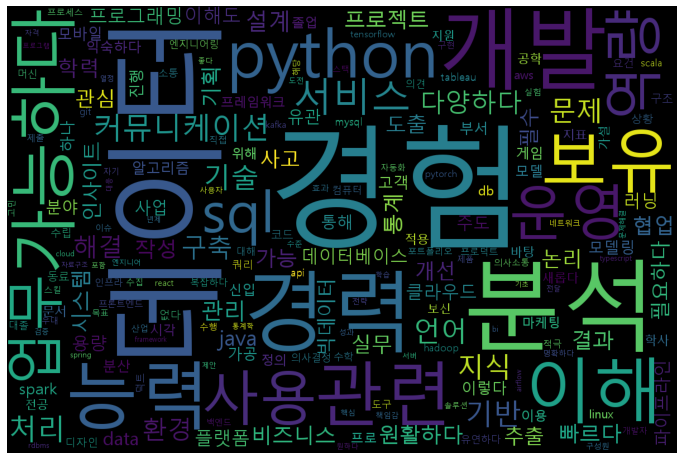

In [26]:
# 워드클라우드 시각화 
wc=WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', background_color='black', width=1200, height=800)
cloud=wc.generate_from_frequencies(dict(word_count))

plt.figure(figsize=(12,12))
plt.imshow(cloud)
plt.axis('off')
plt.show()